In [70]:
# 데이터 불러오기
import pandas as pd
import numpy as np

df = pd.read_csv('/content/samsung_20190102~20220520.csv', index_col=0, header=0, encoding='cp949',sep=',', parse_dates=True)
df = df.sort_values(['일자'], ascending = True)
df

,시가,고가,저가,종가,거래량
일자,,,,,
2019-01-02,39400,39400,38550,38750,7847664
2019-01-03,38300,38550,37450,37600,12471493
2019-01-04,37450,37600,36850,37450,14108958
2019-01-07,38000,38900,37800,38750,12748997
2019-01-08,38000,39200,37950,38100,12756554
...,...,...,...,...,...
2022-05-16,67100,67400,66100,66300,11937555
2022-05-17,66600,67900,66600,67600,15680447
2022-05-18,68300,68700,67600,68100,16486319


In [71]:
# pandas를 numpy로 변경 후 저장 및 불러오기
np.save('/content/samsung_20190102~20220520.npy', arr = df)
samsung = np.load('/content/samsung_20190102~20220520.npy')

In [72]:
def split_xy5(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset[i:x_end_number, :]
        tmp_y = dataset[x_end_number:y_end_number, 3]
        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x), np.array(y)

x, y = split_xy5(samsung, 5, 1)

In [73]:
# 데이터 나누기
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1, test_size = 0.3)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] * x_test.shape[2]))

print(x_train.shape)
print(x_test.shape)

(581, 25)
(250, 25)


In [74]:
# 데이터 전처리
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train = np.reshape(x_train_scaled, 
                     (x_train_scaled.shape[0], 5, 5))
x_test = np.reshape(x_test_scaled, 
                    (x_test_scaled.shape[0], 5, 5))

print(x_train.shape)
print(x_test.shape)

(581, 5, 5)
(250, 5, 5)


In [91]:
# LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 모델구성
model = Sequential()
model.add(LSTM(128, input_shape=(5, 5)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20)
model.fit(x_train, y_train, validation_split = 0.2, verbose = 1, 
          batch_size = 32, epochs=100, callbacks=[early_stopping])

loss, mse = model.evaluate(x_test, y_test, batch_size = 32)
print('loss: ',loss)
print('mse: ', mse)

y_pred = model.predict(x_test)
for i in range(5):
    print('종가: ', y_test[i], '/ 예측가: ',y_pred[i])

Epoch 1/100
15/15 [==============================] - 4s 48ms/step - loss: 4019925760.0000 - mse: 4019925760.0000 - val_loss: 4177079296.0000 - val_mse: 4177079296.0000
Epoch 2/100
15/15 [==============================] - 0s 11ms/step - loss: 4018945536.0000 - mse: 4018945536.0000 - val_loss: 4174694656.0000 - val_mse: 4174694656.0000
Epoch 3/100
15/15 [==============================] - 0s 11ms/step - loss: 4014287360.0000 - mse: 4014287360.0000 - val_loss: 4166028032.0000 - val_mse: 4166028032.0000
Epoch 4/100
15/15 [==============================] - 0s 11ms/step - loss: 3999915264.0000 - mse: 3999915264.0000 - val_loss: 4141005568.0000 - val_mse: 4141005568.0000
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 3960804608.0000 - mse: 3960804608.0000 - val_loss: 4077495808.0000 - val_mse: 4077495808.0000
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 3869044992.0000 - mse: 3869044992.0000 - val_loss: 3938248448.0000 - val_mse: 39382484

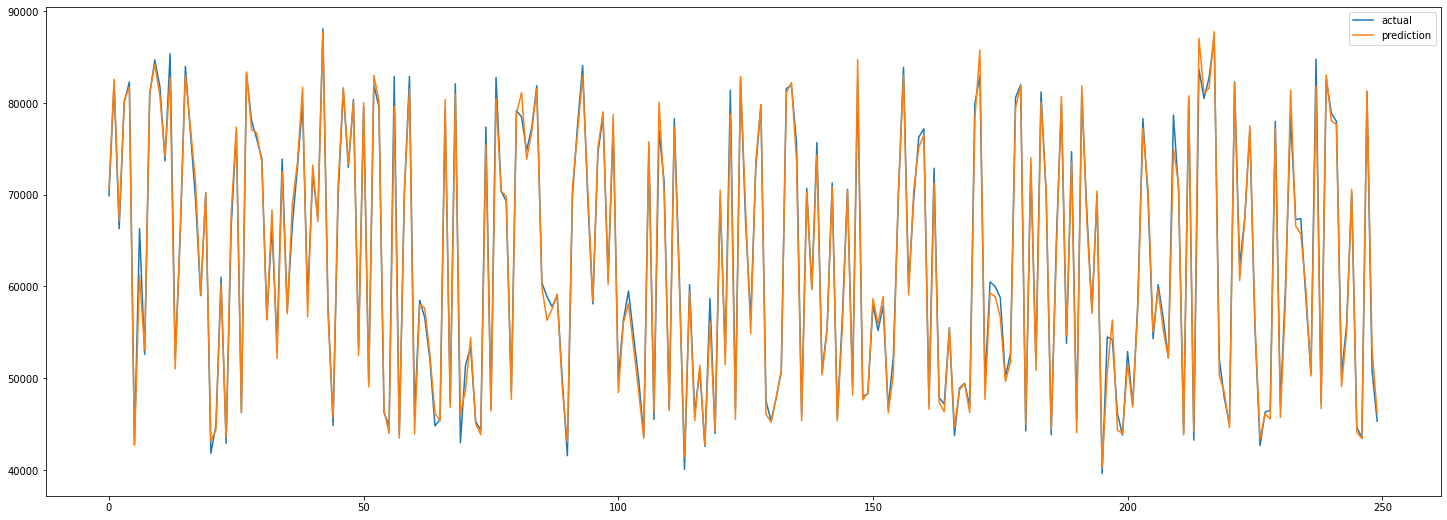

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 9))
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'prediction')
plt.legend()
plt.show()